In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import random
import skimage
from skimage.transform import resize
from pathlib import Path
from scipy.ndimage import gaussian_filter

In [2]:
root = "/Users/kay/Documents/Github/COVID-detection-from-XRay/Data/"

# Iterate over and preprocess image
def preprocess_image(df, img_size = 224):
    # Convert images to numpy array
    df_np = np.empty((len(df), img_size, img_size, 1), dtype=np.float32)

    for i, img_name in enumerate(df):
        try:
            # Read the image
            temp_image = plt.imread(img_name)
            
            # Determine dimensions for cropping
            min_dim = min(temp_image.shape[0], temp_image.shape[1])
            start_x = (temp_image.shape[1] - min_dim) // 2
            start_y = (temp_image.shape[0] - min_dim) // 2
            # Crop the image to make it square
            cropped_image = temp_image[start_y:start_y+min_dim, start_x:start_x+min_dim]
            # Resize the cropped image to the desired size
            img_preprocessed = resize(cropped_image, (img_size, img_size, 1), anti_aliasing=True)

            # Normalize intensity to range (0,1)
            img_preprocessed = skimage.exposure.rescale_intensity(img_preprocessed, in_range='image', out_range=(0, 1))

            # Equalize histogram
            img_preprocessed = skimage.exposure.equalize_hist(img_preprocessed)

            # Add Gaussian blur for denoising
            img_preprocessed = gaussian_filter(img_preprocessed, sigma=1)
            
            # Fill the empty numpy array with preprocessed image
            df_np[i] = img_preprocessed
        except:
            continue
    
    return df_np

In [3]:
# Set seed for reproducibility
random.seed(109)

### BRIXIA - POSITIVE TRAIN DATA
df_brixia = list(Path(os.path.join(root,"Brixia/dicom_clean_png")).glob("*.png"))

# Preprocess images and save
df_brixia_np = preprocess_image(df_brixia)
np.save(os.path.join(os.path.join(root,"Brixia/dicom_clean_png"),"Brixia_preprocessed"), df_brixia_np, allow_pickle=False, fix_imports=False)


### NIHCXR - NEGATIVE TRAIN DATA
# Randomly sample 500 images 
df_nihcxr = random.sample(list(Path(os.path.join(root,"NIHCXR/image1")).glob("*.png")), 500)

# Keep the list of sampled image filenames
image_filenames_500 = [img_path.name for img_path in df_nihcxr]

# Preprocess images and save
df_nihcxr_np = preprocess_image(df_nihcxr)
np.save(os.path.join(os.path.join(root,"NIHCXR/image1"),"NIHCXR_preprocessed"), df_nihcxr_np, allow_pickle=False, fix_imports=False)


### COVIDGR - TEST DATA
df_covidgr_pos = list(Path(os.path.join(root,"COVIDGR_1.0/P")).glob("*.jpg"))
df_covidgr_neg = list(Path(os.path.join(root,"COVIDGR_1.0/N")).glob("*.jpg"))

# Preprocess images and save
df_covidgr_pos_np = preprocess_image(df_covidgr_pos)
df_covidgr_neg_np = preprocess_image(df_covidgr_neg)
np.save(os.path.join(os.path.join(root,"COVIDGR_1.0/P"),"COVIDGR_P_preprocessed"), df_covidgr_pos_np, allow_pickle=False, fix_imports=False)
np.save(os.path.join(os.path.join(root,"COVIDGR_1.0/N"),"COVIDGR_N_preprocessed"), df_covidgr_neg_np, allow_pickle=False, fix_imports=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [4]:
print("NUMBER OF SAMPLES")
print("Brixia - positive train: ", df_brixia_np.shape[0])
print("NIHCXR - negative train: ", df_nihcxr_np.shape[0])
print("COVIDGR - positive test: ", df_covidgr_pos_np.shape[0])
print("COVIDGR - negative test: ", df_covidgr_neg_np.shape[0])

print("IMAGE SIZE (HEIGHT, WIDTH, CHANNELS)")
print(df_covidgr_pos_np.shape[1:])

print("IMAGE DATA TYPE")
print(df_covidgr_pos_np.dtype)

NUMBER OF SAMPLES
Brixia - positive train:  469
NIHCXR - negative train:  500
COVIDGR - positive test:  426
COVIDGR - negative test:  426
IMAGE SIZE (HEIGHT, WIDTH, CHANNELS)
(224, 224, 1)
IMAGE DATA TYPE
float32


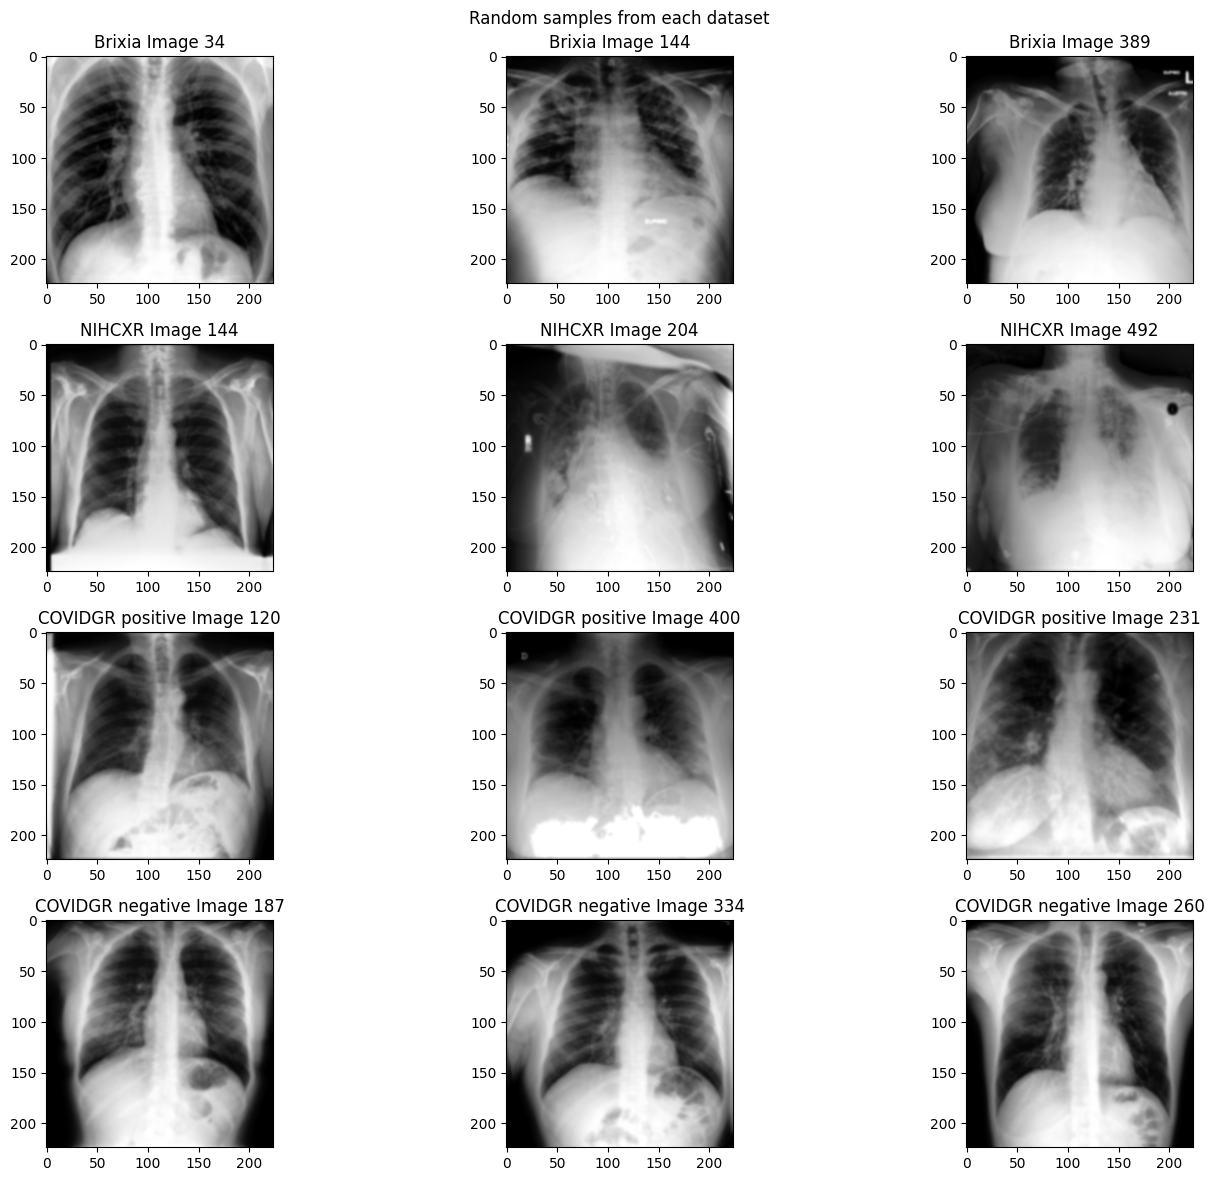

In [24]:
# Create subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 12))

# Plot random samples from each dataset
datasets = [df_brixia_np, df_nihcxr_np, df_covidgr_pos_np, df_covidgr_neg_np]
dataset_index = 0
dataset_names = ['Brixia', 'NIHCXR', 'COVIDGR positive', 'COVIDGR negative']

for row in range(4):
    for col in range(3):
        index = np.random.randint(0, len(datasets[dataset_index]))
        axs[row, col].imshow(datasets[dataset_index][index, :, :, 0], cmap='gray')
        axs[row, col].set_title(f'{dataset_names[dataset_index]} Image {index+1}')
    dataset_index += 1

# Adjust layout to prevent overlap
plt.suptitle("Random samples from each dataset")
plt.tight_layout()

# Show the plot
plt.show()

In [27]:
for dataset, dataset_name in zip(datasets, dataset_names):
    # Calculate descriptive statistics for the current dataset
    avg_intensity = np.mean(np.mean(dataset, axis=(1, 2, 3)))
    max_intensity = np.max(np.mean(dataset, axis=(1, 2, 3)))
    min_intensity = np.min(np.mean(dataset, axis=(1, 2, 3)))
    std_intensity = np.std(np.mean(dataset, axis=(1, 2, 3)))
    std_pixel_values = np.std(dataset)

    # Print descriptive statistics
    print(f"\nDataset: {dataset_name}")
    print("Average image intensity:", avg_intensity)
    print("Maximum image intensity:", max_intensity)
    print("Minimum image intensity:", min_intensity)
    print("Standard deviation of image intensity:", std_intensity)
    print("Standard deviation of pixel values:", std_pixel_values)


Dataset: Brixia
Average image intensity: 0.5037067
Maximum image intensity: 0.5427988
Minimum image intensity: 0.5022224
Standard deviation of image intensity: 0.0021410643
Standard deviation of pixel values: 0.2859215

Dataset: NIHCXR
Average image intensity: 0.50386727
Maximum image intensity: 0.536836
Minimum image intensity: 0.5021633
Standard deviation of image intensity: 0.0034822267
Standard deviation of pixel values: 0.28523302

Dataset: COVIDGR positive
Average image intensity: 0.50364196
Maximum image intensity: 0.57363755
Minimum image intensity: 0.50210845
Standard deviation of image intensity: 0.003745052
Standard deviation of pixel values: 0.28697038

Dataset: COVIDGR negative
Average image intensity: 0.50371665
Maximum image intensity: 0.5221614
Minimum image intensity: 0.502255
Standard deviation of image intensity: 0.0020516776
Standard deviation of pixel values: 0.2860274


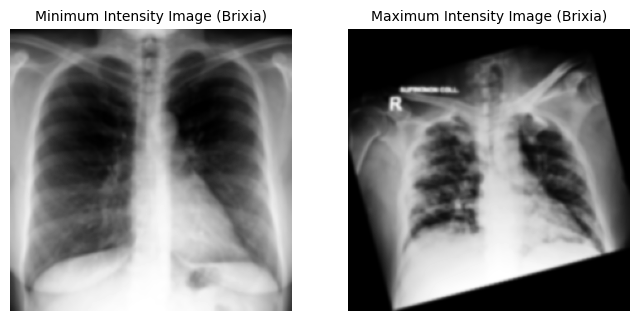

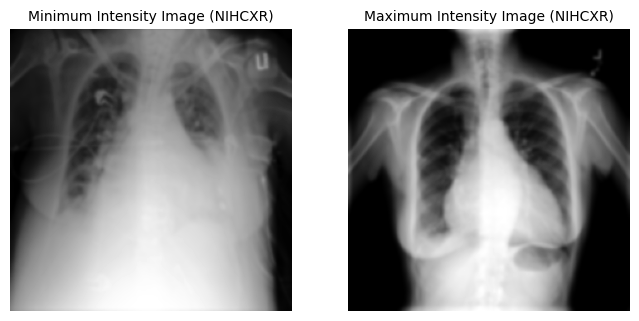

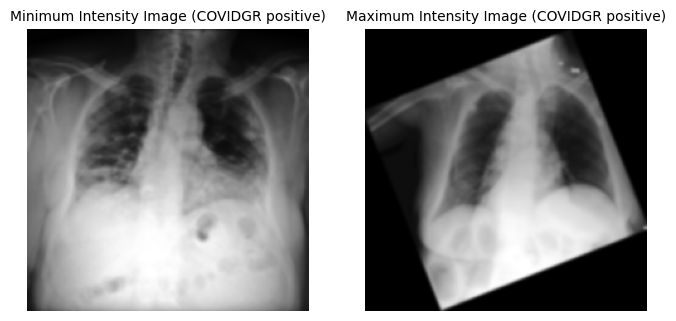

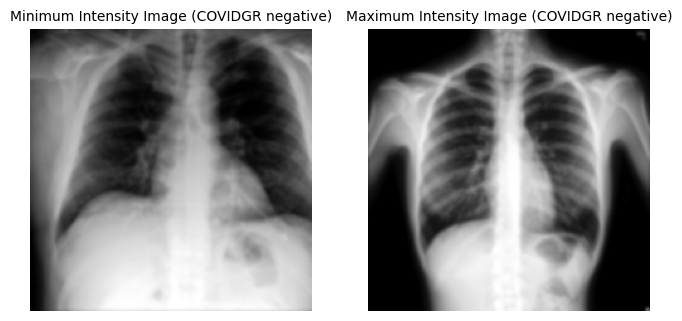

In [26]:
for dataset, dataset_name in zip(datasets, dataset_names):
    # Find the index of the image with minimum intensity
    min_intensity_index = np.argmin(np.mean(dataset, axis=(1, 2, 3)))

    # Find the index of the image with maximum intensity
    max_intensity_index = np.argmax(np.mean(dataset, axis=(1, 2, 3)))

    # Plot the image with minimum intensity
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(dataset[min_intensity_index].squeeze(), cmap='gray')
    plt.title(f'Minimum Intensity Image ({dataset_name})', fontsize=10)
    plt.axis('off')

    # Plot the image with maximum intensity
    plt.subplot(1, 2, 2)
    plt.imshow(dataset[max_intensity_index].squeeze(), cmap='gray')
    plt.title(f'Maximum Intensity Image ({dataset_name})', fontsize=10)
    plt.axis('off')

    plt.show()

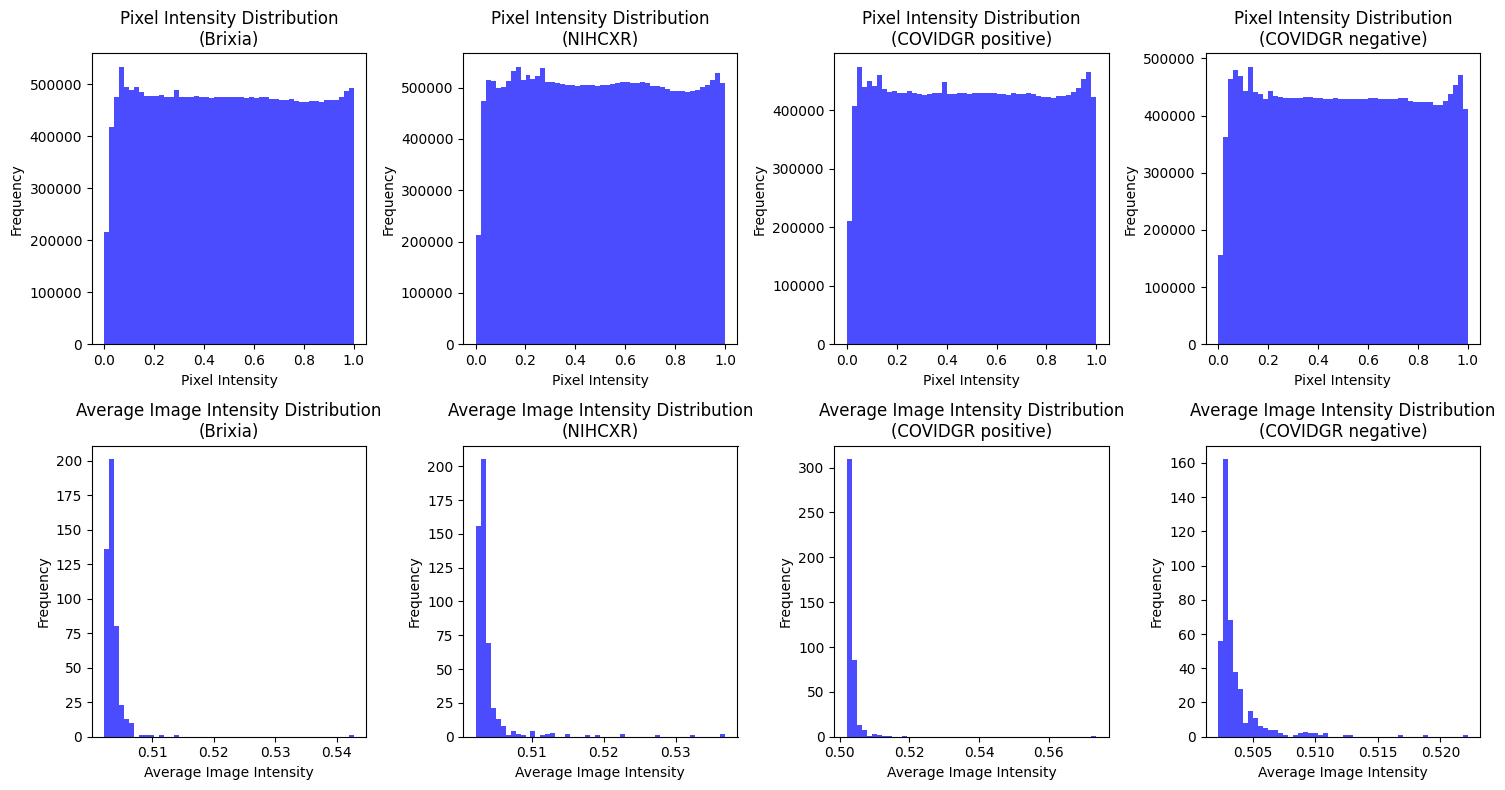

In [29]:
# Define the number of rows and columns for subplots
num_rows = 2
num_cols = len(datasets)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Loop over each dataset
for col, (dataset, dataset_name) in enumerate(zip(datasets, dataset_names)):
    # Flatten the pixel values to compute histogram
    pixel_values = dataset.flatten()

    # Generate histogram for pixel intensity distribution
    axs[0, col].hist(pixel_values, bins=50, color='blue', alpha=0.7)
    axs[0, col].set_title(f'Pixel Intensity Distribution\n({dataset_name})')
    axs[0, col].set_xlabel('Pixel Intensity')
    axs[0, col].set_ylabel('Frequency')

    # Flatten the image values to compute histogram
    image_values = np.mean(dataset, axis=(1,2,3))

    # Generate histogram for average image intensity distribution
    axs[1, col].hist(image_values, bins=50, color='blue', alpha=0.7)
    axs[1, col].set_title(f'Average Image Intensity Distribution\n({dataset_name})')
    axs[1, col].set_xlabel('Average Image Intensity')
    axs[1, col].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<div style="background: #f5f5dc; border: thin solid black; padding: 5px">

Detail the feature engineering process, including transformations, encoding, or selection techniques, with justifications rooted in EDA.

Based on the EDA from Milestone 3 and the TF feedback, we concluded that there were different distributions of the three datasets that we are using for training and testing our model. Furthermore, our original preprocessing approach resulted in some additional image padding and distortion because not all images were square. Thus, further preprocessing of the image data was necessary. We also conducted a review of some of the literature on approaches used in chest x-ray classification for addressing distribution shifts. Broadly, common modelling approaches involve pre-training the model on a large, diverse image dataset and fine-tuning on data specific to a particular distribution, with the pre-training making the model robust to distribution shift (1). Studies that designed chest x-ray classifier models aimed at being generalizable have employed pixel value normalization to values between 0 and 1 (2) and resizing to 224 x 224 pixels (3). Other approaches include histogram equalization to extend the pixel’s intensity range from the original range to 0 to 255 such that the enhanced image has a wider range of intensity and slightly higher contrast, and adding Gaussian blur for noise reduction, which have been found to improve model performance (4). Still other approaches have used segmentation models such as U-net to segment and crop the lungs and convolutional neural networks for bone suppression for feature extraction and to enhance model performance despite distribution shifts (5).

Based on these insights and the EDA findings, we employed new image preprocessing approaches. Specifically, after selecting the images from the original files in the repository, we crop the image retaining the central region to make it square, resize it to 224 x 224 pixels to standardize and ensure uniformity in image dimensions, normalize the image intensity to a range of (0, 1) to reduce brightness level variation across different images, perform histogram equalization to enhance image contrast and make image contrast across datasets more consistent, and add Gaussian blur for denoising purposes, smoothing out the pixel intensity variations in the image. Finally, the images are converted to NumPy arrays to facilitate numerical operations and compatibility with machine learning algorithms. In summary, the feature engineering process aims to standardize and enhance the quality of chest x-ray images for subsequent analysis.

Visualizing the results of these preprocessing steps, we can see that while not all issues with the padding have resolved (eg. some images were pre-rotated to address patient rotation but this resulted in padding at the corners), we were able to resolve the issues with image distortion and differences in pixel and image intensity distributions such that these are approximately similar/consistent across the different datasets. In the future, we may consider further steps to further balance the data in the initial selection process such as balancing patient sex and selecting only chest x-rays with no findings in the NIHCXR (negative train) dataset for further alignment between datasets.

1. https://arxiv.org/pdf/2403.00194.pdf
2. https://www.nature.com/articles/s41598-024-56171-6
3. https://pubs.rsna.org/doi/epdf/10.1148/radiol.2020203511
4. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949
5. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9818166/ 